In [1]:
import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
df = pd.read_csv('../data/new_balanced_data.csv')
df.tail()

Wall time: 541 ms


,short_descriptions,assignment_groups
756695,able desktop not to,Wintel - Citrix
756696,desktop,Wintel - Citrix
756697,citrix,Wintel - Citrix
756698,citrix desktop in not,Wintel - Citrix
756699,able not on to,Wintel - Citrix


In [3]:
vectorizer = joblib.load('../models/vectorizer')
encoder = joblib.load('../models/encoder')

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    11.727765
assignment_groups      0.000000
dtype: float64

In [5]:
df.fillna('', inplace=True)

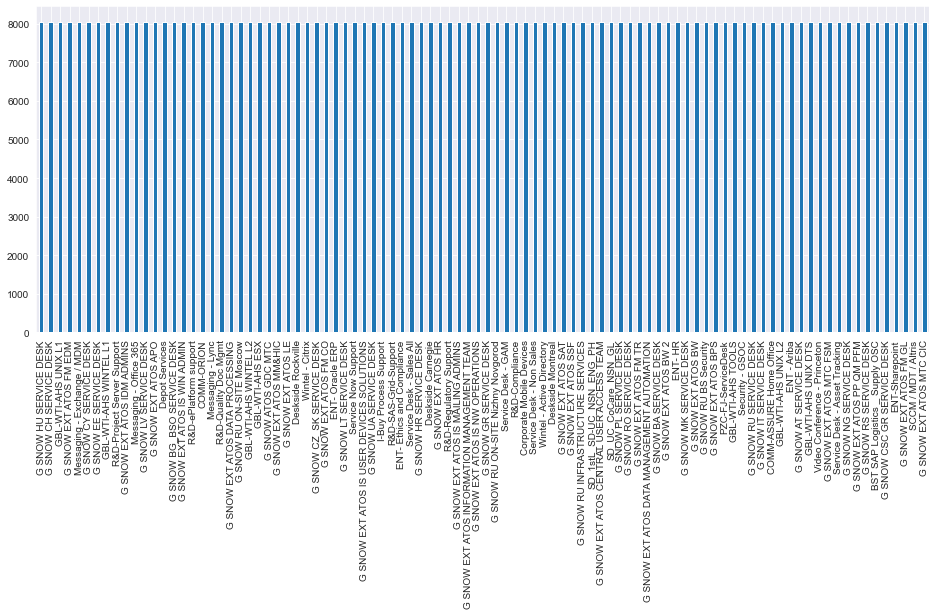

In [6]:
df['assignment_groups'].value_counts().plot(kind='bar', figsize=(16, 6))
plt.show()

In [7]:
X = df['short_descriptions'].values
y = df['assignment_groups'].values

In [8]:
X

array(['power cord for computer',
       'for sap kindly create access pzc51122 on ecp a3493019 8000004716',
       'signature in outlook', ..., 'citrix', 'citrix desktop in not',
       'able not on to'], dtype=object)

In [9]:
y

array(['Service Desk - Non Sales', 'PZC-FJ-ServiceDesk',
       'Service Desk - Non Sales', ..., 'Wintel - Citrix',
       'Wintel - Citrix', 'Wintel - Citrix'], dtype=object)

In [10]:
%%time
X = vectorizer.transform(X)

Wall time: 4.51 s


In [11]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 1.15 s


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(605360, 32737) (605360,) (151340, 32737) (151340,)


In [14]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    XGBClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Acc: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

In [15]:
%%time

trained_models = dict()

for model in models:
    print(f'Training -> {model.__class__.__name__}')
    s = time.time()
    
    trained_models[model.__class__.__name__] = ParallelPostFit(
       estimator=model
    )
    
    trained_models[model.__class__.__name__].fit(X_train, y_train)
    
    e = time.time()
    
    preds = trained_models[model.__class__.__name__].predict(X_test)
    display_metrics(true=y_test, pred=preds)
    
    print(f'Training time: {round(e - s)} seconds')
    print('-' * 10)

Training -> MultinomialNB
Acc: 62.29
F1: 64.45
Precision: 72.52
Recall: 62.29
Training time: 1 seconds
----------
Training -> LogisticRegression
Acc: 66.73
F1: 70.25
Precision: 76.87
Recall: 66.73
Training time: 449 seconds
----------
Training -> RandomForestClassifier
Acc: 69.63
F1: 73.34
Precision: 80.18
Recall: 69.63
Training time: 2959 seconds
----------
Training -> LinearSVC
Acc: 66.37
F1: 69.86
Precision: 76.87
Recall: 66.37
Training time: 1232 seconds
----------
Training -> XGBClassifier


C:\ProgramData\Miniconda3\envs\AIOps\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acc: 4.06
F1: 4.14
Precision: 10.31
Recall: 4.06
Training time: 1254 seconds
----------
Training -> DecisionTreeClassifier
Acc: 69.01
F1: 72.67
Precision: 79.54
Recall: 69.01
Training time: 140 seconds
----------
Wall time: 1h 42min 41s


In [23]:
import joblib

In [24]:
joblib.dump(trained_models['RandomForestClassifier'], '../models/randomforest.joblib', compress=2)

['../models/randomforest.joblib']

In [35]:
test = np.array([
    'HCP restriction removal'
])
test = vectorizer.transform(test)

In [36]:
prediction = trained_models['RandomForestClassifier'].predict(test)

In [38]:
encoder.inverse_transform(prediction)[0]

'Service Desk - Sales All'